In [2]:
#### Import package and data
import numpy as np

import matplotlib.pyplot as plt

import squidpy as sq

adata = sq.datasets.mibitof()

/home/chingyalin/miniconda3/envs/spatial_env/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/home/chingyalin/miniconda3/envs/spatial_env/lib/python3.10/site-packages/anndata/utils.py:434: FutureWarning: Importing read_text from `anndata` is deprecated. Import anndata.io.read_text instead.
  warnings.warn(msg, FutureWarning)


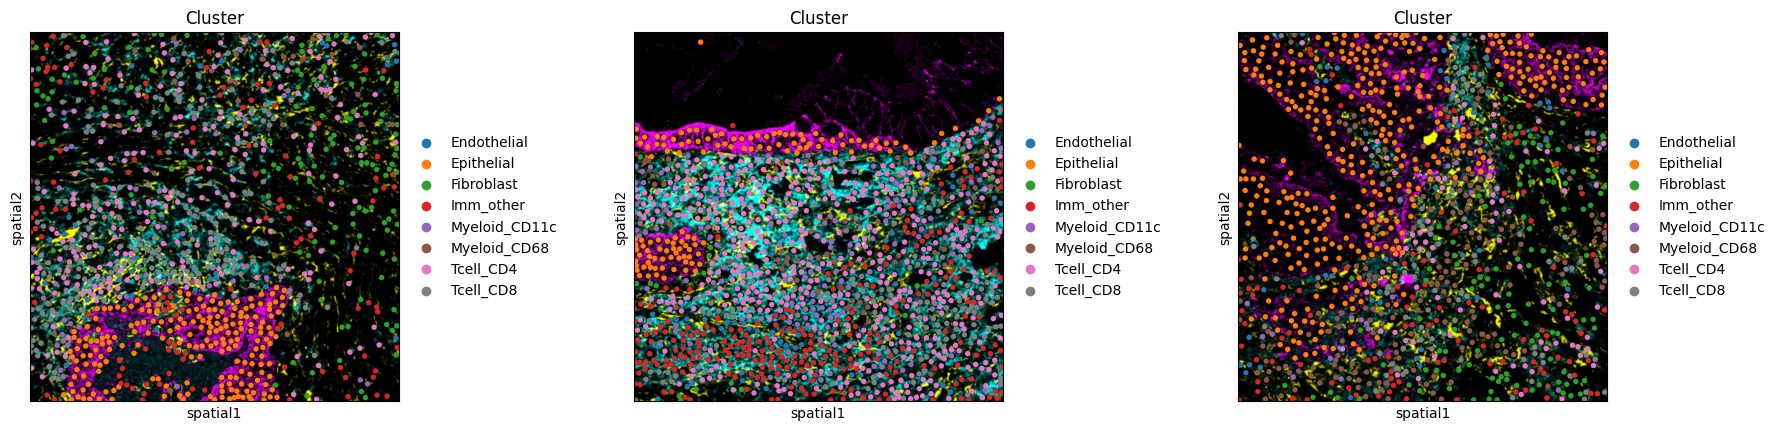

In [27]:
sq.pl.spatial_scatter(
    adata,
    color="Cluster",                 # 依照細胞類型上色
    library_key="library_id",        # 不可省略，指定 biopsy ID
)


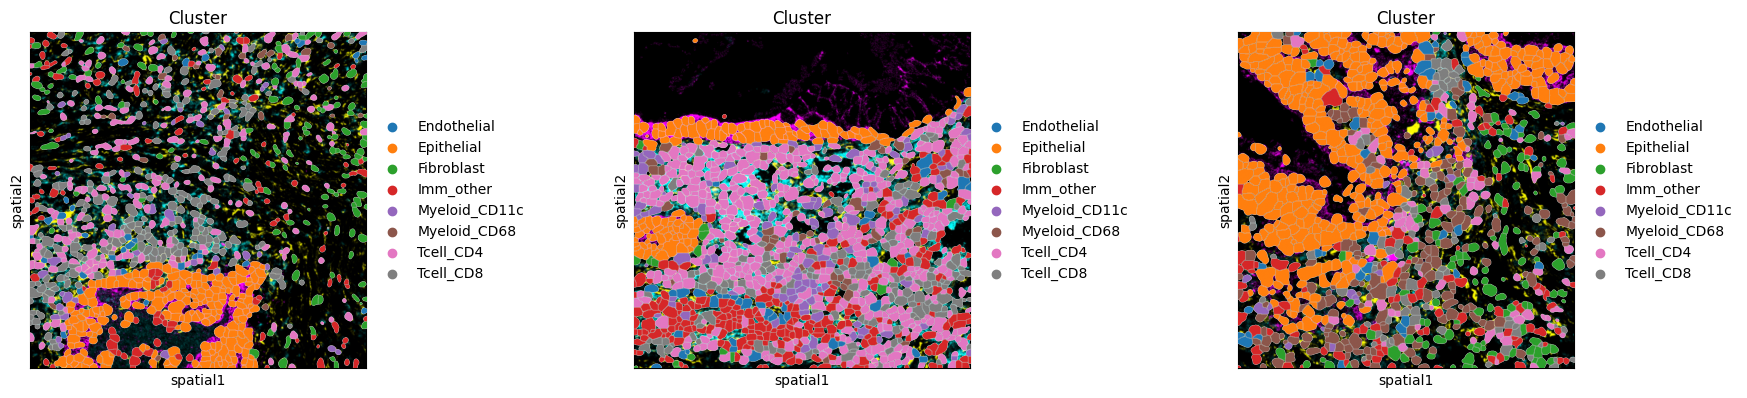

In [28]:
sq.pl.spatial_segment(
    adata, color="Cluster", library_key="library_id", seg_cell_id="cell_id"
)

In [8]:
imgs = []
for library_id in adata.uns["spatial"].keys():
    img = sq.im.ImageContainer(
        adata.uns["spatial"][library_id]["images"]["hires"], library_id=library_id
    )
    img.add_img(
        adata.uns["spatial"][library_id]["images"]["segmentation"],
        library_id=library_id,
        layer="segmentation",
    )
    img["segmentation"].attrs["segmentation"] = True
    imgs.append(img)
img = sq.im.ImageContainer.concat(imgs)

In [9]:
img

ImageContainer[shape=(1024, 1024), layers=['image', 'segmentation']]

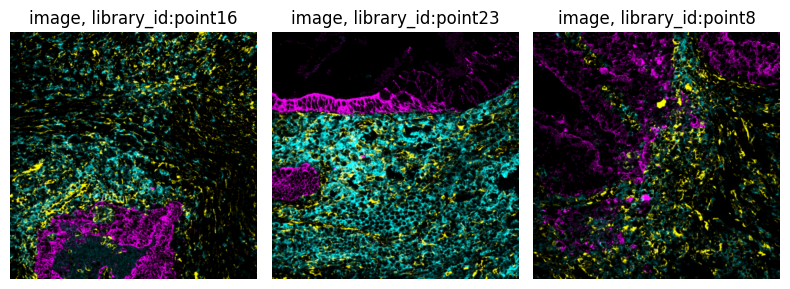

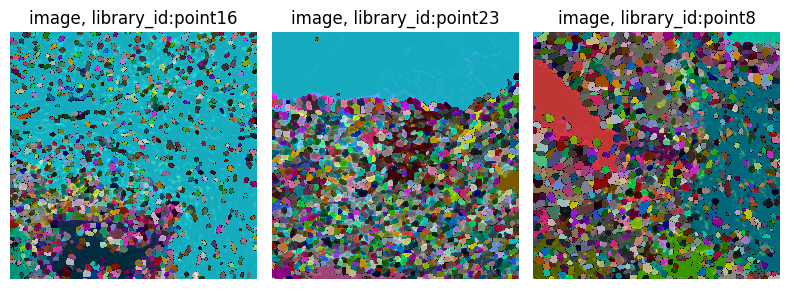

In [63]:
img.show("image")
img.show("image", segmentation_layer="segmentation")

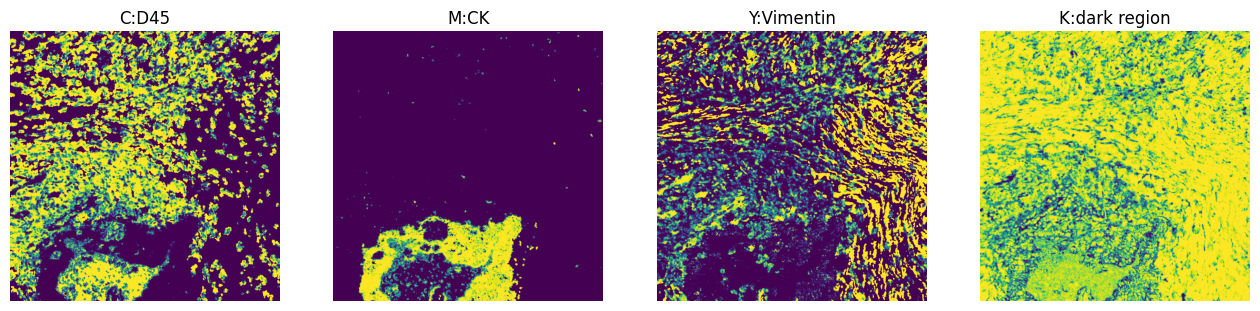

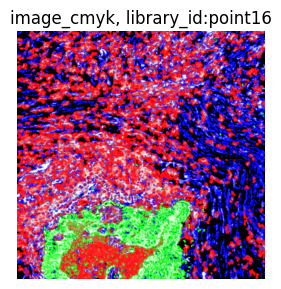

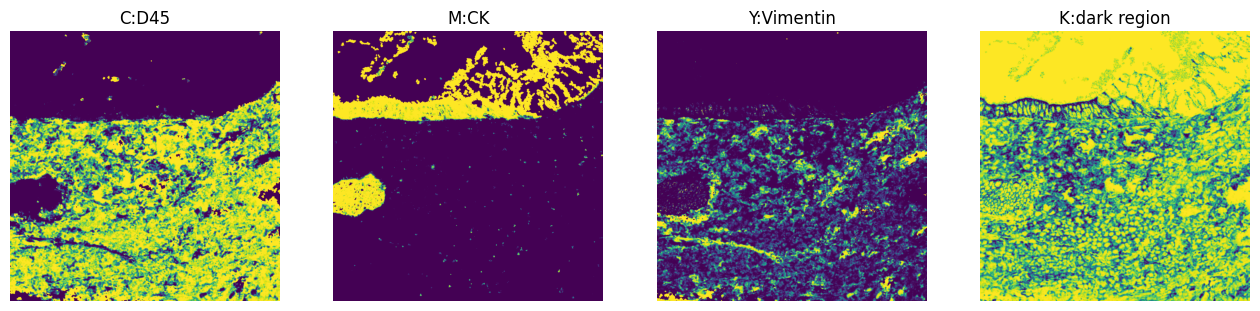

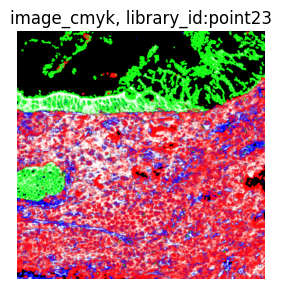

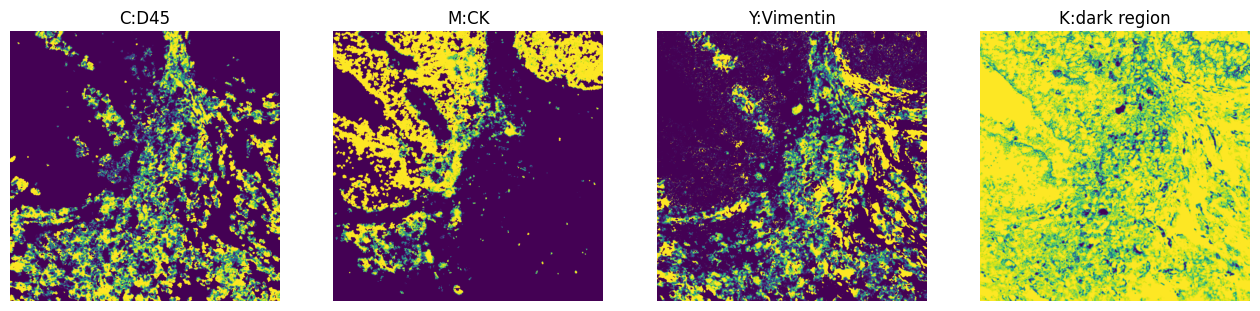

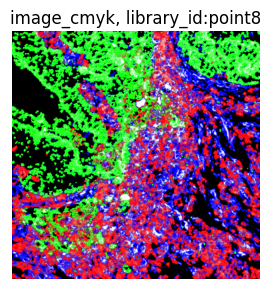

In [88]:
def rgb2cmyk(arr):
    """Convert arr from RGB to CMYK color space."""
    R = arr[..., 0] / 255
    G = arr[..., 1] / 255
    B = arr[..., 2] / 255
    K = 1 - (np.max(arr, axis=-1) / 255)
    C = (1 - R - K) / (1 - K + np.finfo(float).eps)  # avoid division by 0
    M = (1 - G - K) / (1 - K + np.finfo(float).eps)
    Y = (1 - B - K) / (1 - K + np.finfo(float).eps)
    return np.stack([C, M, Y, K], axis=3)


img.apply(rgb2cmyk, layer="image", new_layer="image_cmyk", copy=False)
titles=["C:D45", "M:CK", "Y:Vimentin", "K:dark region"]
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
img.show("image_cmyk", library_id="point16", figsize=(4, 3), channelwise=True, ax=axs)
for i in range(len(axs)):
    axs[i].set_title(titles[i])
img.show("image_cmyk", library_id="point16", figsize=(4, 3))

fig, axs = plt.subplots(1, 4, figsize=(16, 4))
img.show("image_cmyk", library_id="point23", figsize=(4, 3), channelwise=True, ax=axs)
for i in range(len(axs)):
    axs[i].set_title(titles[i])
img.show("image_cmyk", library_id="point23", figsize=(4, 3))


fig, axs = plt.subplots(1, 4, figsize=(16, 4))
img.show("image_cmyk", library_id="point8", figsize=(4, 3), channelwise=True, ax=axs)
for i in range(len(axs)):
    axs[i].set_title(titles[i])
img.show("image_cmyk", library_id="point8", figsize=(4, 3))

In [12]:
def segmentation_image_intensity(arr, image_cmyk):
    """
    Calculate per-channel mean intensity of the center segment.

    arr: the segmentation
    image_cmyk: the raw image values
    """
    import skimage.measure

    # the center of the segmentation mask contains the current label
    # use that to calculate the mask
    s = arr.shape[0]
    mask = (arr == arr[s // 2, s // 2, 0, 0]).astype(int)
    # use skimage.measure.regionprops to get the intensity per channel
    features = []
    for c in range(image_cmyk.shape[-1]):
        feature = skimage.measure.regionprops_table(
            np.squeeze(mask),  # skimage needs 3d or 2d images, so squeeze excess dims
            intensity_image=np.squeeze(image_cmyk[:, :, :, c]),
            properties=["mean_intensity"],
        )["mean_intensity"][0]
        features.append(feature)
    return features

In [13]:
sq.im.calculate_image_features(
    adata,
    img,
    library_id="library_id",
    features="custom",
    spot_scale=10,
    layer="segmentation",
    features_kwargs={
        "custom": {
            "func": segmentation_image_intensity,
            "additional_layers": ["image_cmyk"],
        }
    },
)

  3%|▎         | 91/3309 [00:00<00:10, 313.39/s]

100%|██████████| 3309/3309 [00:08<00:00, 375.59/s]


In [14]:
adata.obsm["img_features"]

segmentation_image_intensity_0  segmentation_image_intensity_1  \
3034-0                         0.000000                        0.995041   
3035-0                         0.000049                        0.884839   
3036-0                         0.680350                        0.000235   
3037-0                         0.813055                        0.000000   
3038-0                         0.420203                        0.015063   
...                                 ...                             ...   
47342-2                        0.000000                        0.000000   
47343-2                        0.441017                        0.000000   
47344-2                        0.639157                        0.000000   
47345-2                        0.196760                        0.000000   
47346-2                        0.000000                        0.000000   

         segmentation_image_intensity_2  segmentation_image_intensity_3  
3034-0                         0.010664                        0.492503  
3035-0                         0.042991                        0.713101  
3036-0                         0.222640                        0.948284  
3037-0                         0.173941                        0.790169  
3038-0                         0.486171                        0.709584  
...                                 ...                             ...  
47342-2                        0.696113                        0.855720  
47343-2                        0.587986                        0.941870  
47344-2                        0.344870                        0.858989  
47345-2                        0.612479                        0.855991  
47346-2                        0.774775                        0.981311  

[3309 rows x 4 columns]

In [15]:
adata.obsm["img_features_transformed"] = np.arcsinh(adata.obsm["img_features"] / 0.05)

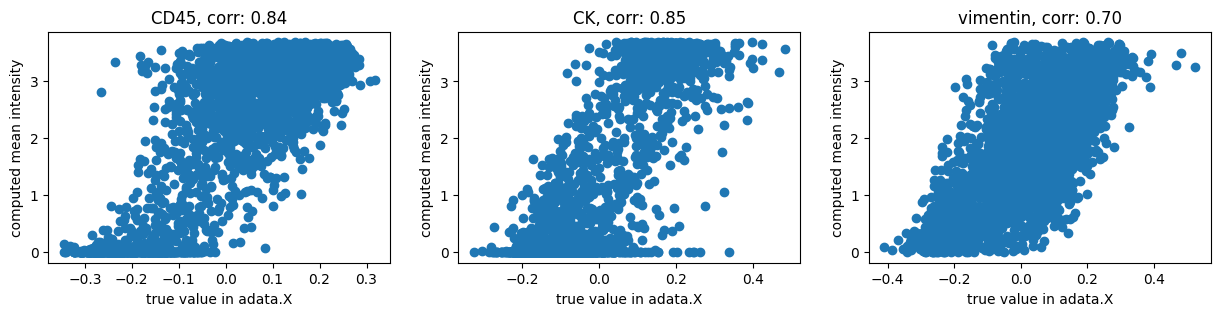

In [ ]:
## 和作者本來提供的表達量對答案
channels = ["CD45", "CK", "vimentin"]

fig, axes = plt.subplots(1, 3, figsize=(15, 3))
for i, ax in enumerate(axes):
    X = np.array(adata[:, channels[i]].X.todense())[:, 0]
    Y = adata.obsm["img_features_transformed"][f"segmentation_image_intensity_{i}"]
    ax.scatter(X, Y)
    ax.set_xlabel("true value in adata.X")
    ax.set_ylabel("computed mean intensity")
    corr = np.corrcoef(X, Y)[1, 0]
    ax.set_title(f"{channels[i]}, corr: {corr:.2f}")

## 其他分析方法

/home/chingyalin/miniconda3/envs/spatial_env/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


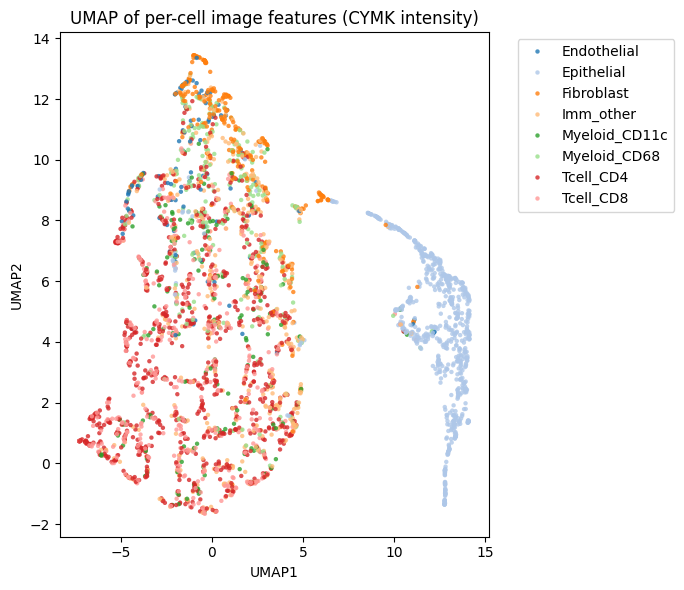

In [110]:
import pandas as pd

# 建 DataFrame：每列是一個 cell，每欄是 marker 強度
df_img = pd.DataFrame(
    adata.obsm["img_features"],
    index=adata.obs.index,
    columns=["segmentation_image_intensity_0", "segmentation_image_intensity_1", "segmentation_image_intensity_2", "segmentation_image_intensity_3"]
)
df_img["Cluster"] = adata.obs["Cluster"]

from sklearn.preprocessing import StandardScaler
import umap

X_scaled = StandardScaler().fit_transform(df_img[["segmentation_image_intensity_0", "segmentation_image_intensity_1", "segmentation_image_intensity_2", "segmentation_image_intensity_3"]])

reducer = umap.UMAP(random_state=42)
umap_coords = reducer.fit_transform(X_scaled)

# 加入 UMAP 結果
df_img["UMAP1"] = umap_coords[:, 0]
df_img["UMAP2"] = umap_coords[:, 1]
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.scatterplot(
    data=df_img,
    x="UMAP1",
    y="UMAP2",
    hue="Cluster",
    palette="tab20",
    s=10,
    linewidth=0,
    alpha=0.8
)
plt.title("UMAP of per-cell image features (CYMK intensity)")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

In [124]:
print(adata)

AnnData object with n_obs × n_vars = 3309 × 36
    obs: 'row_num', 'point', 'cell_id', 'X1', 'center_rowcoord', 'center_colcoord', 'cell_size', 'category', 'donor', 'Cluster', 'batch', 'library_id', 'CD45', 'CK', 'Vimentin', 'K'
    var: 'mean-0', 'std-0', 'mean-1', 'std-1', 'mean-2', 'std-2'
    uns: 'Cluster_colors', 'batch_colors', 'neighbors', 'spatial', 'umap', 'spatial_neighbors', 'Cluster_nhood_enrichment', 'Cluster_co_occurrence', 'Cluster_centrality_scores', 'Cluster_interactions', 'Cluster_ripley_L', 'moranI'
    obsm: 'X_scanorama', 'X_umap', 'spatial', 'img_features', 'img_features_transformed'
    obsp: 'connectivities', 'distances', 'spatial_connectivities', 'spatial_distances'


In [130]:
import squidpy as sq
import pandas as pd
import numpy as np

# Step 0: 建立 spatial neighbors graph
# adata_subset = adata[adata.obs.library_id == "point16"].copy() -> 也可以做單獨切片的下列分析, 只是 adata 就要改成 adata_subset

sq.gr.spatial_neighbors(adata, coord_type="generic")  # 適用於 MIBI-TOF 或一般座標


100%|██████████| 1000/1000 [00:00<00:00, 7034.21/s]


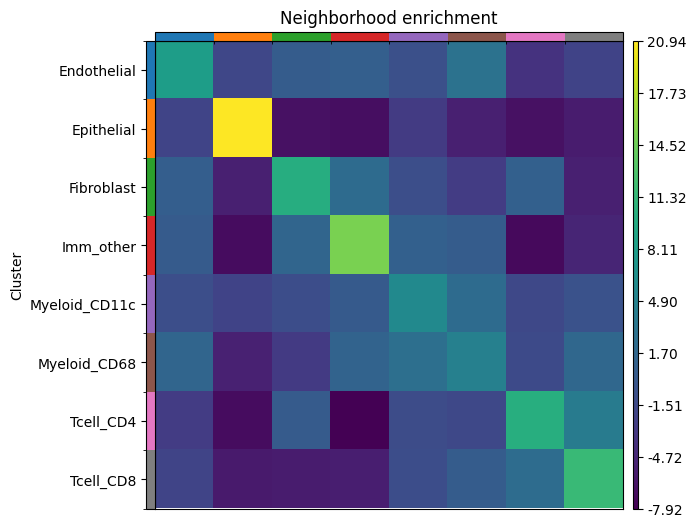

In [131]:
# Step 1: Neighborhood enrichment（哪些 cell type 喜歡靠近）
sq.gr.nhood_enrichment(adata, cluster_key="Cluster")
# Neighborhood enrichment heatmap
sq.pl.nhood_enrichment(adata, cluster_key="Cluster")

100%|██████████| 1/1 [00:01<00:00,  1.60s/]


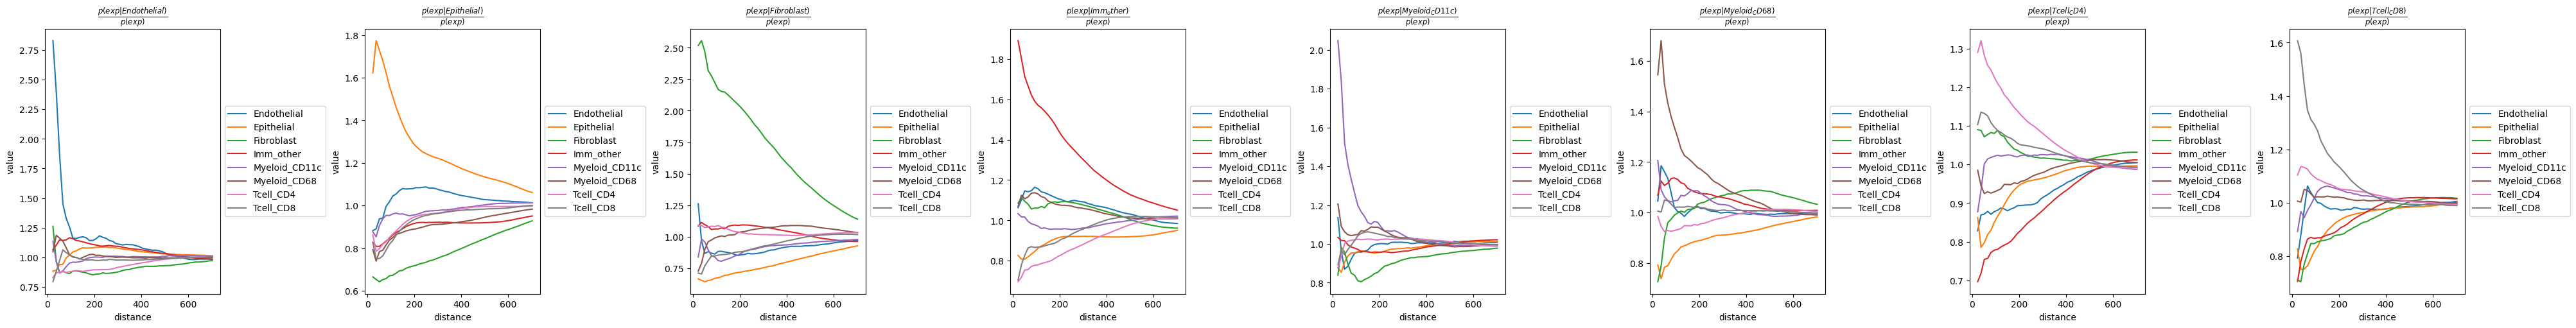

In [132]:

# Co-occurrence plot
# Step 2: Co-occurrence（局部區域中 cell type 共現機率）
sq.gr.co_occurrence(adata, cluster_key="Cluster")
sq.pl.co_occurrence(adata, cluster_key="Cluster")


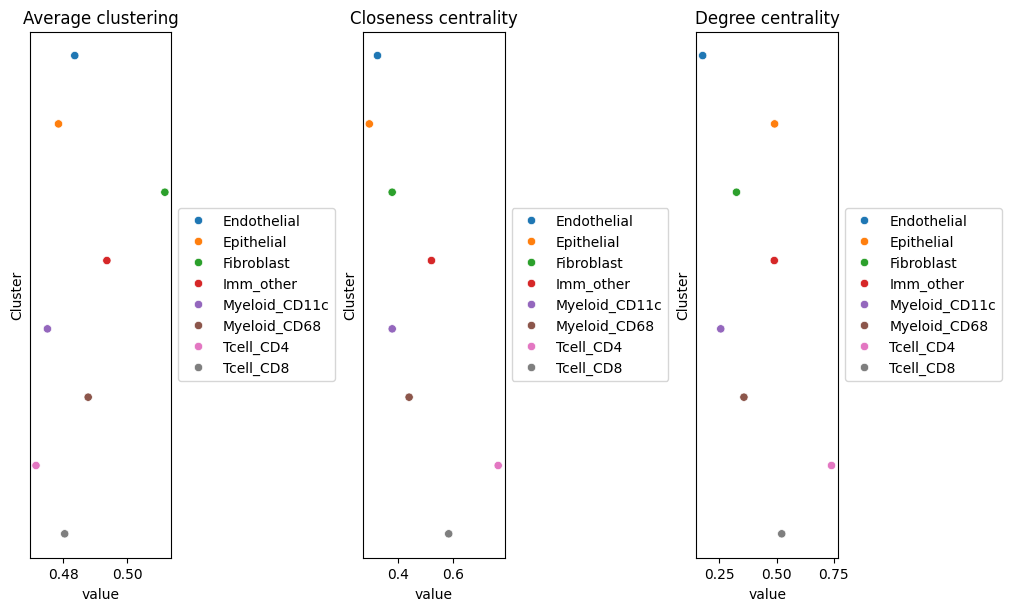

In [133]:

# Step 3: Centrality score（哪種 cell type 是空間 hub）
sq.gr.centrality_scores(adata, cluster_key="Cluster")
sq.pl.centrality_scores(adata, cluster_key="Cluster",figsize=(10, 6))


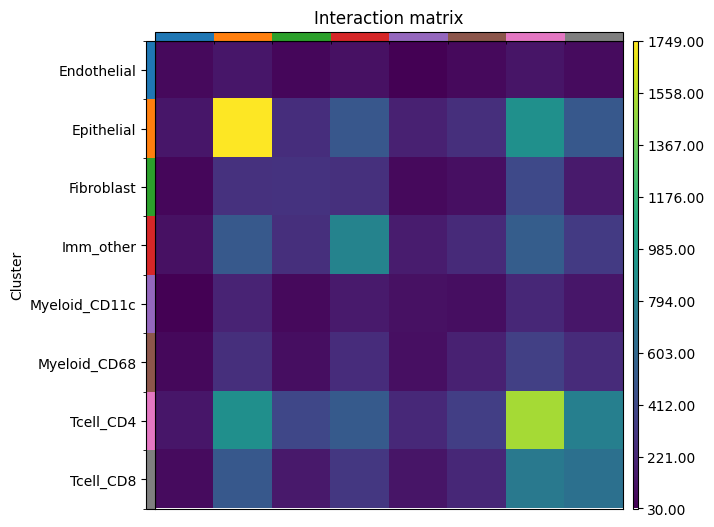

In [134]:
# Step 4: Interaction matrix（Cluster 間空間鄰近次數）
sq.gr.interaction_matrix(adata, cluster_key="Cluster")
# Interaction matrix heatmap
sq.pl.interaction_matrix(adata, cluster_key="Cluster")

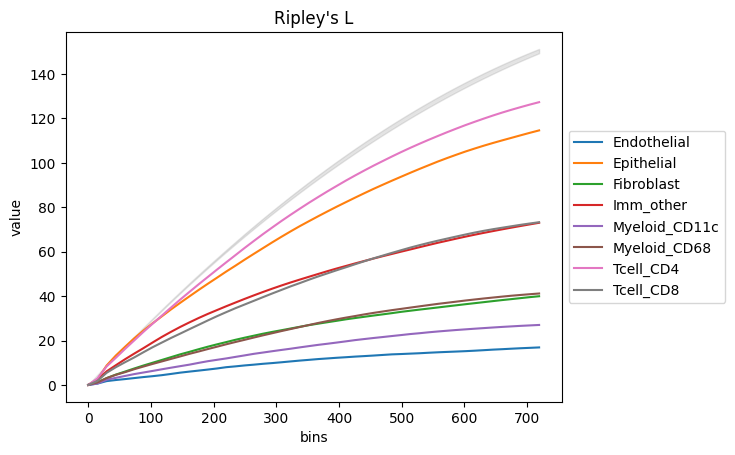

In [123]:

# Step 5: Ripley's L statistic（某 cell type 是否聚集）
sq.gr.ripley(adata, cluster_key="Cluster", mode="L")  # 可改為 mode="L" 看 L function
# Ripley's L 曲線圖
sq.pl.ripley(adata, cluster_key="Cluster", mode="L")